# Topic Contiguity 

Topic contiguity refers to the relationship of topics to each other in practice, not to their similarity. From the perspective of an associationist epistemology, contiguity is the opposite of similarity. Contiguous topics are those that co-occur frequently enough to suggest "syndromes." For example, if the topics of genetic engineering and acquaculture are contiguous, this suggests an assemblage of practices relating to the application of a kind of knowledge to a specific industry. We use pointwise mutual information  to surface topic contiguity, similar to how this concept is used in association rule mining.

# Set Up

## Imports

In [1]:
import pandas as pd
import numpy as np
from lib import tapi

## Configuration

In [2]:
tapi.list_dbs()

['anphoblacht',
 'jstor_hyperparameter',
 'jstor_hyperparameter_demo',
 'okcupid',
 'tamilnet',
 'winereviews']

In [3]:
data_prefix = 'jstor_hyperparameter_demo'
topic_glosses = ['Bayesian models', 'French', 'MCMC', 'priors', 'economics', 'random effects', 'variable selection',
                 'empirical Bayes', 'env biology', 'genetics']

## Import Topic Data

We import our previously generated model.

In [4]:
db = tapi.Edition(data_prefix)

In [5]:
db.get_tables()

LABELS
VOCAB
BOW
TOPICS
DTM not found
THETA
PHI
TOPICS_NMF
THETA_NMF
PHI_NMF


In [6]:
if len(topic_glosses) > 0:
    db.TOPICS_NMF['gloss'] = topic_glosses # THIS SHOULD BE DONE EARLIER IN THE PIPELINE
else:
    db.TOPICS_NMF['gloss'] = db.TOPICS_NMF.topwords.str.extract(r'^(.{20})')

# Compute Contiguity

## By Correlation

### Create Topic Pairs

In [7]:
topic_pairs = db.THETA_NMF.corr().stack().to_frame('topic_corr')
topic_pairs.index.names = ['t1', 't2']
topic_pairs = topic_pairs.loc[topic_pairs.apply(lambda x: x.name[0] < x.name[1], 1)]

topic_pairs['z_score'] = (topic_pairs.topic_corr - topic_pairs.topic_corr.mean()) / topic_pairs.topic_corr.std()
topic_pairs['t1_gloss'] = topic_pairs.apply(lambda x: db.TOPICS_NMF.loc[x.name[0]].gloss, 1)
topic_pairs['t2_gloss'] = topic_pairs.apply(lambda x: db.TOPICS_NMF.loc[x.name[1]].gloss, 1)

In [8]:
topic_pairs.sort_values('topic_corr', ascending=False).head(10)

topic_corr   z_score            t1_gloss            t2_gloss
t1 t2                                                              
6  7     0.097966  2.096024  variable selection     empirical Bayes
0  2     0.069323  1.647788     Bayesian models                MCMC
   5     0.045801  1.279689     Bayesian models      random effects
3  6     0.038231  1.161238              priors  variable selection
2  6     0.016686  0.824074                MCMC  variable selection
5  7     0.015219  0.801125      random effects     empirical Bayes
8  9     0.007242  0.676280         env biology            genetics
6  9     0.005250  0.645117  variable selection            genetics
3  7     0.004493  0.633272              priors     empirical Bayes
7  9     0.001965  0.593711     empirical Bayes            genetics

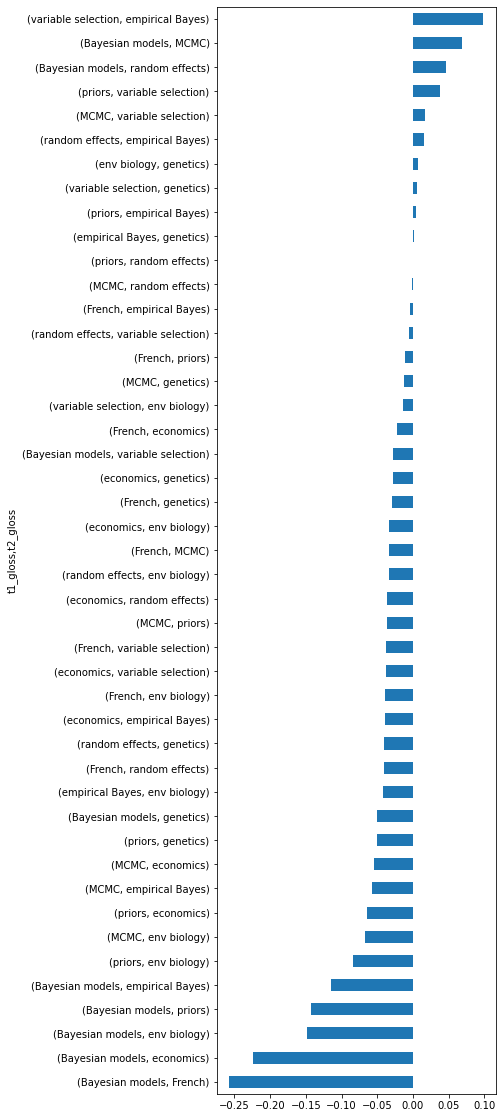

In [9]:
topic_pairs.reset_index().set_index(['t1_gloss','t2_gloss']).topic_corr.sort_values()\
    .plot.barh(figsize=(5, db.n_topics * 2), legend=False);

### View Network

In [10]:
import pydot
from IPython.display import SVG, display

In [11]:
def show_graph(thresh = 1, measure='topic_corr'):
    
    graph = pydot.Dot('topic_graph', graph_type='graph')

    nodes = []
    for i in topic_pairs[topic_pairs[measure] >= thresh].index:

        nodes.append(i[0])
        nodes.append(i[1])

        m = topic_pairs.loc[i][measure].round(2)    
        graph.add_edge(pydot.Edge(i[0], i[1], 
                                  label=m, 
                                  color='lightgray', 
                                  fontsize=10, 
                                  fontcolor='green',
                                  fontname='Arial'))

    for node in list(set(nodes)):
        node_gloss = 'T' + str(node) + ": " + db.TOPICS_NMF.loc[node, 'gloss']
        graph.add_node(pydot.Node(node, 
                                  label=node_gloss, 
                                  shape='plain', 
                                  fontname='Arial'))

    display(SVG(graph.create_svg()))

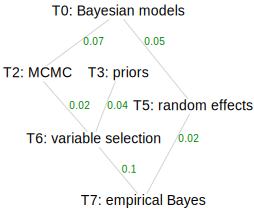

In [12]:
show_graph(0.01)

## By Mutual Information

### Compute Marginal Probabilities

In [13]:
db.TOPICS_NMF['p'] = db.THETA_NMF.sum() / db.THETA_NMF.sum().sum()

### Compute Joint Probabilities

In [14]:
tw_thresh = 0

In [15]:
N = db.THETA_NMF.shape[0]

In [16]:
topic_pairs['p_ab'] = topic_pairs.apply(lambda x: 
                                        db.THETA_NMF[(db.THETA_NMF[x.name[0]] > tw_thresh) 
                                        & (db.THETA_NMF[x.name[1]] > tw_thresh)].shape[0] / N, 1)

In [17]:
topic_pairs.sort_values('p_ab', ascending=False).head(10)

topic_corr   z_score         t1_gloss            t2_gloss      p_ab
t1 t2                                                                     
0  3    -0.142843 -1.672402  Bayesian models              priors  0.359175
   2     0.069323  1.647788  Bayesian models                MCMC  0.248933
   5     0.045801  1.279689  Bayesian models      random effects  0.185633
   6    -0.027794  0.128002  Bayesian models  variable selection  0.164296
   7    -0.114099 -1.222584  Bayesian models     empirical Bayes  0.159317
2  3    -0.036570 -0.009324             MCMC              priors  0.106686
0  8    -0.148066 -1.754125  Bayesian models         env biology  0.093883
3  7     0.004493  0.633272           priors     empirical Bayes  0.082504
0  4    -0.224053 -2.943256  Bayesian models           economics  0.069701
3  6     0.038231  1.161238           priors  variable selection  0.068990

### Compute PWMI

"Pointwise  mutual  information  (PMI,  5)  is  a  measure  of  how  much  the  actual probability of a particular co-occurrence of events $p(x, y)$ differs from what we would expect it to be on the basis of the probabilities of the individual events and the assumption of independence $p(x)$ $p(y)$."

[Bouma, Gerlof (2009). "Normalized (Pointwise) Mutual Information in Collocation Extraction." _Proceedings of the Biennial GSCL Conference_.](https://svn.spraakdata.gu.se/repos/gerlof/pub/www/Docs/npmi-pfd.pdf)

In [18]:
import math

In [19]:
def pwmi(p_a, p_b, p_ab):
    """Computes the adjusted point-wise mutual information of two items (a and b)
    that appear in container vectors of some kind, e.g. items in a shopping
    basket."""

    if p_ab > 0:
        pmi_ab = math.log2(p_ab / (p_a * p_b))  # Raw
        h = p_ab * math.log2(1/p_ab)
        apmi_ab = pmi_ab / h
    else:
        apmi_ab = 0

    return apmi_ab

In [20]:
topic_pairs['pwmi'] = topic_pairs.apply(lambda x: pwmi(db.TOPICS_NMF.loc[x.name[0]].p, 
                                                       db.TOPICS_NMF.loc[x.name[1]].p,
                                                      x.p_ab), 1)

In [21]:
topic_pairs.sort_values('pwmi', ascending=False).head(10)

,,topic_corr,z_score,t1_gloss,t2_gloss,p_ab,pwmi
t1,t2,,,,,,
8,9,0.007242,0.676280,env biology,genetics,0.007824,30.254576
7,9,0.001965,0.593711,empirical Bayes,genetics,0.009246,28.354478
4,5,-0.036030,-0.000874,economics,random effects,0.012802,28.187914
6,9,0.005250,0.645117,variable selection,genetics,0.015647,26.762923
4,7,-0.039842,-0.060536,economics,empirical Bayes,0.006401,25.799801
5,8,-0.034222,0.027415,random effects,env biology,0.016358,25.479394
4,8,-0.032969,0.047028,economics,env biology,0.004979,25.386916
6,8,-0.013321,0.354488,variable selection,env biology,0.010669,25.362109
7,8,-0.041499,-0.086460,empirical Bayes,env biology,0.007824,24.542186


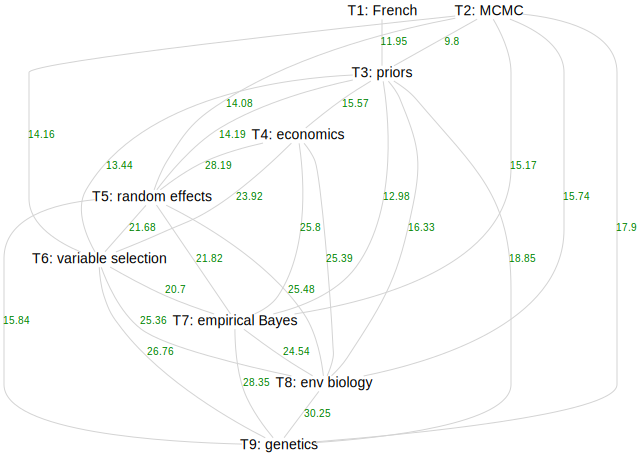

In [31]:
show_graph(topic_pairs.pwmi.quantile(.4), 'pwmi')

## Compare Contiguity Measures

In [32]:
import plotly_express as px

In [33]:
labels = topic_pairs[['t1_gloss','t2_gloss']].apply(lambda x: '<br>'.join(x), 1)

In [34]:
px.scatter(topic_pairs, 'topic_corr', 'pwmi', size='p_ab', text=labels, height=1000, width=1000)

In [26]:
px.scatter_3d(topic_pairs, 'topic_corr', 'pwmi', 'p_ab', text=labels, height=1000, width=1000)